In [1]:
%matplotlib inline

import pandas as pd

from matplotlib import pyplot as plt
from pyspark.sql import HiveContext
from pyspark.sql import functions as f

En las celdas siguientes configuramos un enlace para acceder a los datos de Hive y definimos dos Spark Dataframes que harán referencia a los datos de las dos tablas externas de Hive (voto_csv y usuario_csv).

In [2]:
hive = HiveContext(sc)

sdf_votos = sqlContext.table('voto_csv')
sdf_usuarios = sqlContext.table('usuario_csv')

Una vez inicializados estos objetos en Spark, podemos mostrar su modelo de datos para comprobar que todo es correcto.

In [3]:
sdf_votos

DataFrame[id_galaxia: bigint, id_usuario: int, forma: int, tiempo: float]

In [4]:
sdf_usuarios

DataFrame[id_usuario: int, edad: int, pais: string]

# Estudio y limpieza de los datos de usuario

Para empezar, vamos a mostrar algunos registros de usuarios usando el método *show*

In [5]:
sdf_usuarios.show(5)

+----------+----+----------+
|id_usuario|edad|      pais|
+----------+----+----------+
|         1|  39|   Bolívia|
|         3|  40| Nicaragua|
|         4|  36|    España|
|         5|  26| Argentina|
|         6|  28|Costa Rica|
+----------+----+----------+
only showing top 5 rows



Y podemos contar cuantos usuarios han participado en total usando la método *count()*.

In [6]:
sdf_usuarios.count()

14919

## País

Para empezar, vamos a generar un histograma con los paises de todos los usuarios que han participado usando las funcionalidades presentes en Spark.

In [10]:
hist_usuarios_pais = sdf_usuarios.groupby('pais').count().toPandas()
hist_usuarios_pais.head(21)

,pais,count
0,Guatemala,461
1,Colombia,1636
2,Bolívia,358
3,Nicaragua,207
4,Chile,530
5,Puerto Rico,141
6,Cuba,368
7,Paraguay,220
8,México,4170
9,Perú,1006


La celda anterior agrupa los usuarios según su país y luego cuenta el número de usuarios que hay en cada grupo (país).
Vamos a visualizarlo con un histograma.

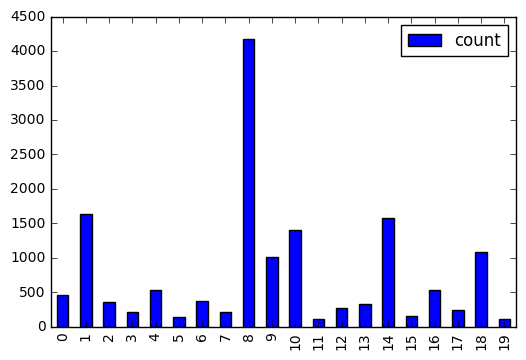

In [8]:
hist_usuarios_pais.plot(kind='bar')

En el gráfico anterior, en el eje X nos muestra la posición en lugar del nombre del país. Para cambiar esto, nos conviene definir el índice del Pandas DataFrame usando el método *set_index*.

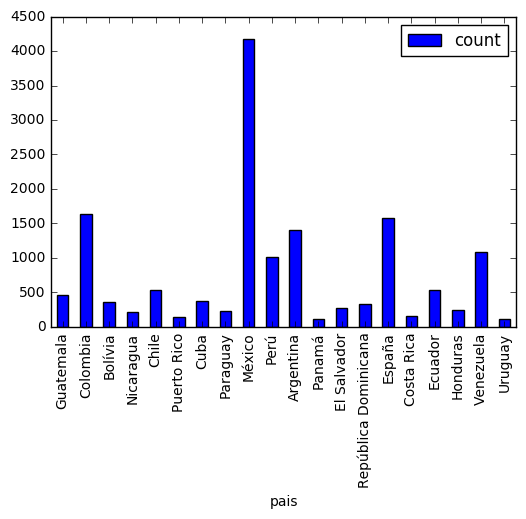

In [11]:
hist_usuarios_pais.set_index('pais').plot(kind='bar')

Ahora podemos ver claramente que el país que más participantes ha tenido (más de 4000) ha sido México, y el que menos, parece ser Uruguay. Como no queda muy claro, vamos a ordenar los valores de este histograma usando el método *sort_values*. Ejecuta la celda siguiente para ver el resultado:

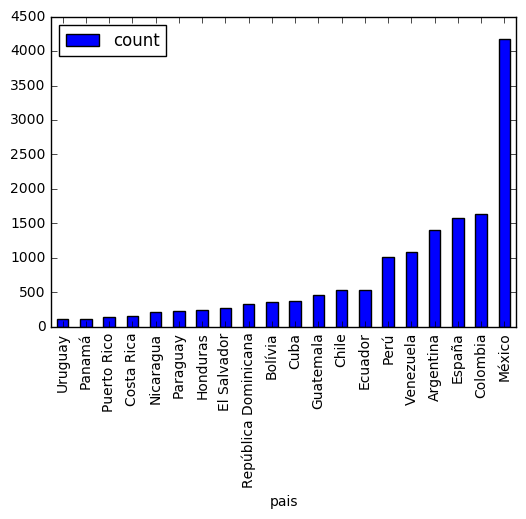

In [12]:
hist_usuarios_pais.set_index('pais').sort_values('count').plot(kind='bar')

Ahora sí podemos ver claramente que Uruguay es el país que menos participantes ha tenido, aunque seguido bien de cerca por Panamá o Puerto Rico, entre otros.

## Edad

En segundo lugar, vamos a estudiar la distribución de edades de los participantes. Para ello, vamos a construir un histograma muy similar al anterior pero, en este caso, en lugar de agrupar por país, vamos a agrupar por edad.

In [57]:
hist_usuarios_edad = sdf_usuarios.groupby('edad').count().toPandas()
hist_usuarios_edad.head() 


,edad,count
0,31,433
1,32,410
2,33,460
3,34,515
4,35,550


Para mostrar los datos de este histograma usaremos otro tipo de gráfico, llamado "scatter".

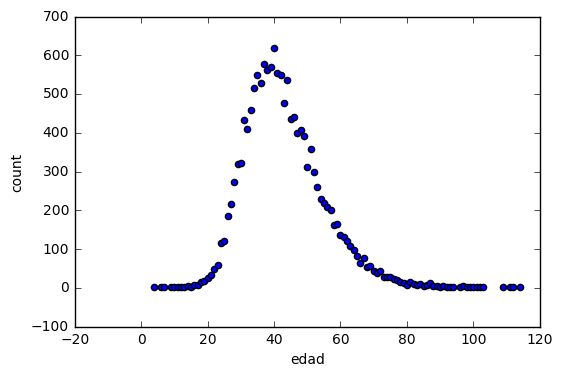

In [16]:
hist_usuarios_edad.plot('edad', 'count', kind='scatter')

En este gráfico podemos ver como hay participantes menores de 10 años y mayores de 100. Más adelante nos va a interesar filtrar los votos de estos usuarios, pues pueden ser poco fiables. Vamos a ver cuantos usuarios hay que tengan menos de 10 años.

In [18]:
sdf_usuarios.filter('edad < 10').count()

8

Ahora vamos a averiguar cuántos usuarios mayores de 100 años han participado.

In [21]:
sdf_usuarios.filter('edad > 100').count()

7

Vamos a generar el conjunto de datos limpio filtrando sólo los usuarios que tengan edades comprendidas entre los 20 y los 80 años, ambos incluidos.Así desechamos posibles errores y eliminamos valores extremos que aunque sean posibles,no es lo mas lógico.Contaremos el número total.

In [58]:
sdf_usuarios_limpio = sdf_usuarios.filter('edad >= 20 AND edad <= 80')
sdf_usuarios_limpio.count()

14749

# Estudio y limpieza de los datos de votos

Una vez analizados los datos de los usuarios, vamos a hacer lo mismo con los votos.

In [23]:
sdf_votos.show(5)

+------------------+----------+-----+---------+
|        id_galaxia|id_usuario|forma|   tiempo|
+------------------+----------+-----+---------+
|587739829276311756|     10404|    1| 6.614253|
|587744728760910031|     10404|    1| 35.48929|
|587738195050823924|     10404|    0|2.5945048|
|587735349639184468|     10404|    1|3.2181664|
|588017726552015023|     10404|    1| 7.687656|
+------------------+----------+-----+---------+
only showing top 5 rows



Y podemos contar cuantos votos hemos recodigo en total usando la método *count()*.

In [24]:
sdf_votos.count()

379149

## Tiempo de respuesta

Ahora vamos a estudiar la distribución del tiempo de respuesta, para ver cómo de rápido han sido los participantes a la hora de clasificar las galaxias según su forma.

Como puedes observar en el resultado mostrado en la celda anterior, en este caso tenemos una complejidad adicional que es el hecho de que el tiempo de respuesta no es un valor con el cual podamos agrupar directamente, ya que no es un valor categórico y cada voto tiene un tiempo de respuesta distinto.

Para poder agrupar los distintos votos, deberemos crear categorías artificiales, por ejemplo agrupando los tiempos de respuesta en bloques de un segundo. Para llevar a cabo esta agrupación podemos usar la función *floor* en la que, dado un tiempo de respuesta, nos va a devolver la parte entera despreciando la parte decimal. De esta manera, varios votos que hayan tardado 3.425, 3.019 o 3.978 segundos van a quedar agrupados en la misma categoria, los que han tardado de 3 a 4 segundos.

Vamos a generar esta columna extra con el método *withColumn* aplicando esta función *floor*.

In [59]:
sdf_votos.withColumn('segundos', f.floor('tiempo')).show(10)

+------------------+----------+-----+---------+--------+
|        id_galaxia|id_usuario|forma|   tiempo|segundos|
+------------------+----------+-----+---------+--------+
|587739829276311756|     10404|    1| 6.614253|       6|
|587744728760910031|     10404|    1| 35.48929|      35|
|587738195050823924|     10404|    0|2.5945048|       2|
|587735349639184468|     10404|    1|3.2181664|       3|
|588017726552015023|     10404|    1| 7.687656|       7|
|588010358014017710|     10404|    0| 9.799089|       9|
|587737826752594182|     10404|    1| 5.225004|       5|
|587739304222130394|     10404|    0| 5.303747|       5|
|587739828736032881|     10404|    1| 5.341632|       5|
|588017979433353325|     10404|    1|21.725706|      21|
+------------------+----------+-----+---------+--------+
only showing top 10 rows



Ahora ya sí podemos agrupar por esta columna nueva y generar el histograma.

In [60]:
hist_votos_tiempo = sdf_votos.withColumn('segundos', f.floor('tiempo')).groupby('segundos').count().toPandas()
hist_votos_tiempo.head()

,segundos,count
0,31,1497
1,32,1315
2,33,1218
3,34,1109
4,35,1004


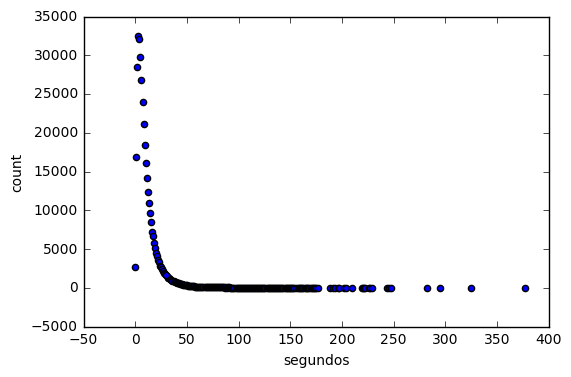

In [61]:
hist_votos_tiempo.plot('segundos', 'count', kind = 'scatter')

Lo primero que podemos ver en este gráfico es que parece ser que hay clasificaciones donde el usuario se ha tomado su tiempo para decidirse. Hay bastantes votos en los que el usuario ha necesitado más de 60 segundos para decidirse, incluso algunos han tardado más de 300 segundos (5 minutos). Es muy probable que no nos interese tener en cuenta estos votos, ya que la información que contienen podría ser problemática.

Calculamos el número de votos que han tomado 60 segundos o más en generarse.

In [62]:
sdf_votos.filter('tiempo >= 60').count()

2866

Por otro lado, en la visualización anterior perdemos el detalle de lo que sucede para tiempos reducidos. Hay un parámetro *xlim* que se le puede pasar al método *plot* para especificar el rango que queremos que nos muestre en el eje X. Añadimos este parámetro con el valor [-1, 30] en la siguiente celda y volvemos a generar el gráfico.

In [63]:
sdf_votos.filter('tiempo > 180').count()

31

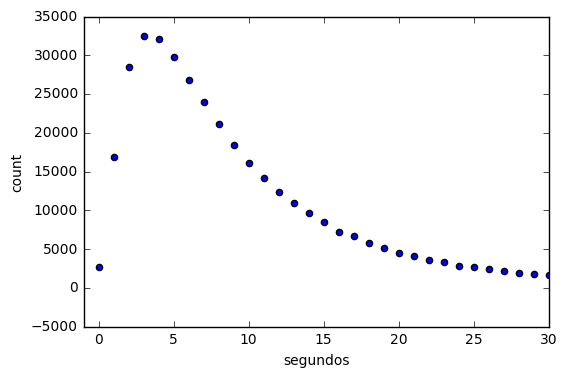

In [64]:
hist_votos_tiempo.plot('segundos', 'count', kind = 'scatter', xlim=[-1,30])

Podemos observar como hay algunas clasificaciones que se han realizado en menos de un segundo o menos, ya que aparecen agrupadas en la coordenada 0. Calculamos el número de votos que se han realizado en menos de medio segundo 

In [39]:
sdf_votos.filter('tiempo < 0.5 ').count()

179

Estos votos también podría interesarnos no tenerlos en cuenta, ya que es bastante probable que el usuario no le haya prestado suficiente atención.

Por último generaremos un conjunto de datos limpio que sólo contenga los votos en los que el tiempo de respuesta sea mayor de medio segundo e igual o menor que 30.

In [65]:
sdf_votos_limpio = sdf_votos.filter('tiempo >= 0.5 AND tiempo <= 30')
sdf_votos_limpio.show(5)

+------------------+----------+-----+---------+
|        id_galaxia|id_usuario|forma|   tiempo|
+------------------+----------+-----+---------+
|587739829276311756|     10404|    1| 6.614253|
|587738195050823924|     10404|    0|2.5945048|
|587735349639184468|     10404|    1|3.2181664|
|588017726552015023|     10404|    1| 7.687656|
|588010358014017710|     10404|    0| 9.799089|
+------------------+----------+-----+---------+
only showing top 5 rows



Usamos el método *count* en este conjunto de datos limpio para calcular cuantos votos nos han quedado después de sanear los datos.

In [66]:
sdf_votos_limpio.count()

358090

# Combinación de los datos limpios

Ahora que tenemos los dos conjuntos de datos limpios, vamos a combinarlos para estudiarlos en su conjunto. Para ello usaremos el método *join* para combinar ambos por la columna que tienen en común, que es el identificador del usuario.

In [67]:
sdf_combinado = sdf_votos_limpio.join(sdf_usuarios_limpio, 'id_usuario')
sdf_combinado.show(10)

+----------+------------------+-----+---------+----+-----+
|id_usuario|        id_galaxia|forma|   tiempo|edad| pais|
+----------+------------------+-----+---------+----+-----+
|        31|587725492136378490|    0| 8.714862|  41|Chile|
|        31|587728906102571431|    1|1.3004789|  41|Chile|
|        31|588017978368983145|    0|2.7923298|  41|Chile|
|        31|587726015087575240|    1| 6.563765|  41|Chile|
|        31|587727226231455809|    1|13.529812|  41|Chile|
|        31|588298664647393452|    1| 8.112954|  41|Chile|
|        31|588023240207106090|    0|21.317204|  41|Chile|
|        31|587739294550982840|    0| 9.660184|  41|Chile|
|        31|587739406260896014|    0|20.625921|  41|Chile|
|        31|588017724396601544|    1|5.2223186|  41|Chile|
+----------+------------------+-----+---------+----+-----+
only showing top 10 rows



Al combinar estos dos conjuntos de datos vamos a generar un conjunto de datos aún más limpio, ya que en la combinación se van a descartar todos los votos de aquellos usuarios que hemos filtrado por estar fuera del rango de edad.

Calculamos el número de registros del conjunto de datos combinados con el método *count*.

In [68]:
sdf_combinado.count()

355170

## Votos según el país

Ahora que tenemos los datos combinados, podemos sacar información adicional sobre estos datos. Por ejemplo, podemos calcular el histograma de número de votos por país.

In [46]:
hist_votos_pais = sdf_combinado.groupby('pais').count().toPandas()
hist_votos_pais.head()

,pais,count
0,Guatemala,11575
1,Colombia,40772
2,Bolívia,9043
3,Nicaragua,5242
4,Chile,13217
5,Puerto Rico,3514
6,Cuba,9236
7,Paraguay,5511
8,México,103782
9,Perú,25503


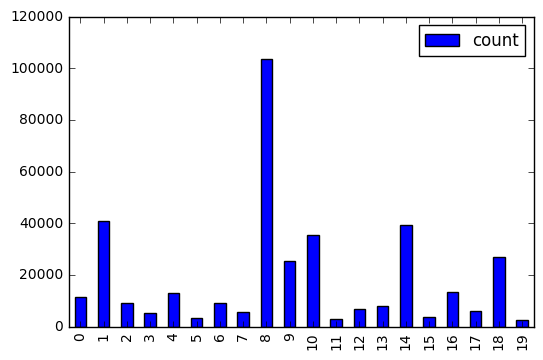

In [45]:
hist_votos_pais.plot(kind='bar')

Al igual que nos pasó al mostrar los datos del número de usuarios por país, en este gráfico nos aparece la posición del país en lugar de su nombre.Vamos a generar una visualización donde aparezca el nombre el país en el eje X y los valores del histograma estén ordenados.

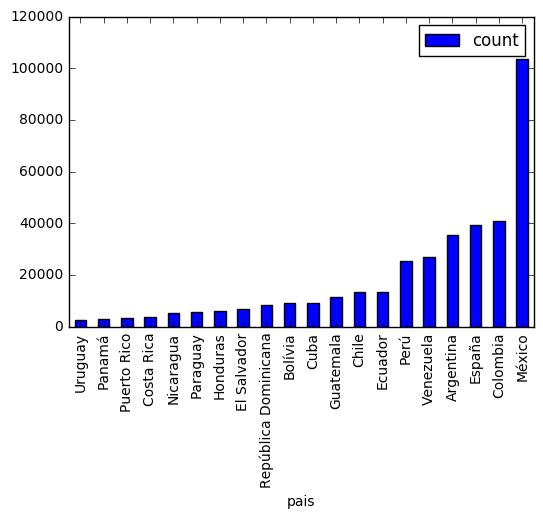

In [48]:
hist_votos_pais.set_index('pais').sort_values('count').plot(kind='bar')

Como era de esperar México sigue liderando en el recuento de votos al tener también el mayor número de usuarios participantes.

El problema con esta visualización es que no podemos determinar si los usuarios de México o los de cualquier otro país han sido más productivos que el resto. Es decir, si los usuarios de algún país han sido generado, de media, más votos de los de otros países. Para saber esto, podemos calcular el número medio de votos por usuario de cada país, dividiendo los datos de los dos histogramas (el de número de votos por país y el de número de usuarios por país).

In [50]:
hist_media_voto_pais = hist_votos_pais.set_index('pais') / hist_usuarios_pais.set_index('pais')
hist_media_voto_pais.head(20)

,count
pais,
Guatemala,25.108460
Colombia,24.921760
Bolívia,25.259777
Nicaragua,25.323671
Chile,24.937736
Puerto Rico,24.921986
Cuba,25.097826
Paraguay,25.050000
México,24.887770


Vamos a visualizar esta información ahora con un gráfico de barras.

In [ ]:
hist_media_voto_pais.plot(kind='bar')

A la vista de la información presentada, no parece haber diferencias significativas en la participación de los usuarios de cada país. De media, cada participante ha clasificado la forma de unas 25 galaxias.

## Votos según la edad

Sucederá lo mismo si estudiamos el número de votos medio segun la franja de edad?

In [ ]:
hist_votos_edad = sdf_combinado.groupby('    ').count().toPandas()
hist_votos_edad.head()

In [ ]:
hist_votos_edad.plot('    ', '     ', kind='scatter')

A primera vista vemos una distribución del número de votos según la edad muy similar a la distribución de usuarios según la edad. Esto era esperable ya que las franjas con más usuarios también serán las que deberían haber generado más clasificaciones. Para poder salir de dudas, es necesario hacer como en el caso anterior y dividir la información de los dos histogramas para calcular el número medio de votos segun la edad.

In [ ]:
hist_media_voto_edad = hist_votos_edad.set_index('edad') / hist_usuarios_edad.set_index('edad')
hist_media_voto_edad.head(10)

Si vemos algun valor 'NaN' en la tabla anterior, corresponden a datos de usuarios o votos que han sido filtrados (por edad o tiempo).

In [ ]:
hist_media_voto_edad.reset_index().plot('edad', 'count', kind='scatter')

# Generar la clasificación promedio

Una vez hemos limpiado y estudiado los datos y estamos conformes con su validez, es el momento de generar la clasificación ideal de cada una de las galaxias. Para ello, vamos a promediar el voto de todos los usuarios sobre cada una de las galaxias. Al habernos preocupado previamente de guardar la forma como un número (0 en caso de votar elíptica, y 1 en caso de votar espiral), esta operación va a ser muy sencilla. Si la mayoría de los usuarios han votado una imagen de una galaxia como elíptica, la media de sus votos debería ser cercana a 0. En caso contrario, si la mayoría de los votos han marcado una galaxia como espiral, la media de la columna forma debería ser cercana a 1.

Antes de continuar, recordemos el aspecto del conjunto de datos combinado con el método show.

In [ ]:
sdf_combinado.show(5)

Para generar la clasificación promedio, debemos agrupar por la columna que identifica únicamente a cada galaxia y calcular la media del campo forma. Completa la celda siguiente y ejecútala:

In [ ]:
sdf_clasificado = sdf_combinado.groupby('          ').agg(f.avg('forma').alias('forma'))
sdf_clasificado.show(5)

En la celda anterior podemos ver como para cada galaxia hemos obtenido su forma esperada segun la media de los votos. El último paso que nos queda es guardar esta información en otra tabla, que va a ser usada en la semana siguiente para entrenar un clasificador automatizado.

In [ ]:
sdf_clasificado.write.saveAsTable('target', mode='overwrite')